Aim to complete as much of this tutorial on your own *before* coming to the practical session.

Use the practical session to get help for any aspect you do not understand or were unable to complete.

# Dimensionality Reduction 1

Learning objectives
1. Apply PCA to different data sets and interpret the output using the popular python library [sklearn](https://scikit-learn.org/stable/)
2. Learn how to visualise the model output
3. Interpret the results to learn about the data structure and potential outliers
4. Code your own function to perform scaling (centering and auto-scaling) using only the numpy.mean and numpy.std functions and two datasets as input (training, test)
5. Investigate the effect of scaling the data on the output

## Import specific packages and functions

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler

## Read in the omics datasets using the pandas [read_excel()](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html) function.
For this example we will be using some COVID19 proteomics data.

**It is important that the Data folder is placed in the same location as the folders of each of the notebooks.** Otherwise you need to edit the data path in each notebook. Here it goes back to the parent directory of this Notebook and then into the Data-main folder to load the dataset.

In [2]:
covid_proteomics = pd.read_excel("../Data-main/COVID19_proteomics.xlsx")

In [3]:
covid_proteomics.head(20)

,COVID19,sample_time,sample_id,"lectin, galactoside-binding, soluble, 9","tumor necrosis factor receptor superfamily, member 10a",agouti related protein homolog (mouse),"tumor necrosis factor receptor superfamily, member 10b","tumor necrosis factor receptor superfamily, member 13B",c-fos induced growth factor (vascular endothelial growth factor D),dickkopf WNT signaling pathway inhibitor 1,...,"EGF-like-domain, multiple 7",REST corepressor 1,carbonic anhydrase XIV,syntaxin 8,"protein kinase, AMP-activated, beta 1 non-catalytic subunit",mitogen-activated protein kinase kinase kinase kinase 5,negative regulator of ubiquitin-like proteins 1,ectonucleoside triphosphate diphosphohydrolase 2,"melanoma antigen family D, 1",G protein-coupled receptor 56
0,0,0,1010823,9.467005,3.150612,4.765860,5.853070,9.776093,8.076783,10.286002,...,5.089420,1.904315,2.354585,3.370510,1.457120,6.393335,1.888595,1.272365,-1.015575,1.774740
1,0,0,1027114,2.414755,1.457353,1.244160,0.712265,2.301213,0.910362,-0.073302,...,5.737120,1.706265,2.174810,2.320480,0.754500,3.058775,0.745930,1.413305,-1.683045,1.542735
2,0,0,1029090,9.581175,3.121713,4.649250,5.796290,9.494383,8.618412,9.356512,...,5.046855,1.923825,2.362200,3.534835,1.649450,5.595935,2.099020,1.539440,-0.599360,1.543860
3,0,0,1049423,9.391395,3.068790,4.669920,5.773255,11.887820,7.702655,9.278815,...,4.665445,1.910215,2.364895,3.594625,1.468635,5.781550,1.864265,1.657420,-0.094040,1.229660
4,0,0,1057525,9.142025,3.198663,5.430080,5.614800,9.746692,8.250982,9.407002,...,5.510625,1.770395,2.533960,3.393515,1.293010,5.925985,1.124380,1.383710,-0.680310,1.763090
5,0,0,1065558,9.520395,3.261270,4.810595,5.796090,9.716400,7.394165,9.578205,...,4.844270,1.815715,2.229780,2.416590,0.494190,4.416565,0.394440,1.336955,-1.091685,1.358405
6,0,0,1066842,9.704675,3.327310,4.735280,7.927645,9.807930,7.085200,9.988565,...,5.578100,1.840535,2.070480,3.841480,1.509670,5.866515,1.869450,1.275495,-0.489305,2.541955
7,0,0,1075315,9.398315,3.133215,4.500165,5.613260,9.180295,8.329575,10.057185,...,5.476575,2.504045,3.081320,3.754045,2.359585,7.841550,2.747405,1.555540,0.038790,1.650520
8,0,0,1097616,10.115740,3.683935,4.306665,5.763435,9.662610,7.859150,9.829915,...,5.615135,1.915235,2.611660,4.715735,2.075320,7.149175,1.929220,1.437280,0.332150,1.697690
9,0,0,1100090,9.711635,3.305100,4.718785,5.954905,9.393805,8.046555,9.877380,...,5.301765,1.962355,2.603330,4.142485,1.839545,5.733170,2.374105,1.158960,-0.173210,3.355640


We can see the data has three metadata colums: COVID19 (disease status), sample_time (when the blood draw was taken), and sample_id.

## Principal Component Analysis (PCA)
Read more about PCA in the sklearn [documentation](https://scikit-learn.org/stable/modules/decomposition.html#pca)

Use the sklearn [PCA()](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) function to initialise a PCA object. What is the maximum number of components you can have for a PCA model?

In [4]:
pca_res = PCA(n_components=4)
# run PCA with 4 components

Apply the `fit_transform()` function to the PCA object to perform PCA dimensionality reduction on the data and project the data to the latent space. Note: we must exclude any sample metadata columns beforehand (remember Python starts counting at 0). 

In [5]:
# covid_proteomics.iloc[:, 3:] dataframe without the first 3 metadata columns
pca_covid = pca_res.fit_transform(covid_proteomics.iloc[:, 3:])

By appling `fit_transform` we project the proteomics data into the latent subspace captured by PCA. The results, also known as **PCA scores** are stored in the results of `fit_transform`, in our case the variable `pca_covid`. Let's look at the PCA results:

In [6]:
pca_covid

array([[  6.24856647,  -7.36857879,  -4.40201038,   1.36812633],
       [ 40.08553647, -13.39870705,  27.83657184,   4.86126474],
       [ 11.13448435,  -4.11273316,  -3.34527148,   1.06040948],
       ...,
       [ -4.8867819 ,  -6.00553464,   0.48956669,  -3.05076358],
       [-19.00325325,   7.85874695,  -1.33715064,  -3.38606691],
       [-16.43126614,   6.41402614,  -3.59677687,  -4.58113985]])

In [7]:
print(pca_covid.shape)
print(type(pca_covid))

(382, 4)
<class 'numpy.ndarray'>


The results are returned as a numpy array, in this case of size 382 rows (number of samples) by 4 columns (number of components we selected)

We can also obtain the PCA components, **also known as eigenvectors**, which represent the influence of each variable (in this case each protein) within each principal component. We do so using the `components_` attribute of the PCA results. There are 4 rows (components) and 450 columns (proteins).

In [19]:
print(pca_res.components_)
print()
print(pca_res.components_.shape)

[[-0.03303302 -0.02589285 -0.03162731 ... -0.01198025 -0.06189392
  -0.01847887]
 [ 0.06091291  0.07727395  0.03942287 ...  0.01402203  0.01067513
   0.05961235]
 [-0.01455189 -0.02557657 -0.08153593 ... -0.03562647  0.01231284
  -0.06284832]
 [-0.00419266 -0.02049046 -0.00140445 ...  0.06122292  0.0182962
  -0.02878856]]

(4, 450)


## PCA visualisation

Visualise two sets of PCA scores against each other with a PCA biplot.

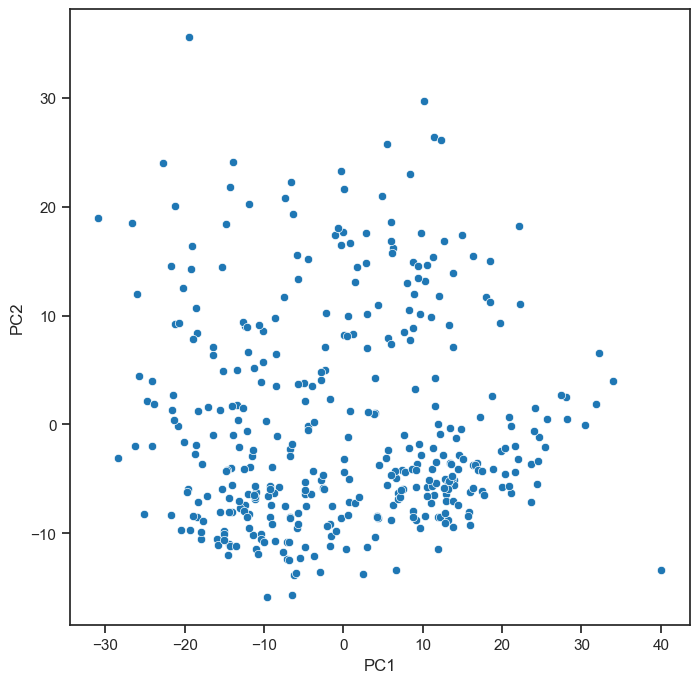

In [9]:
# set plotting parameters
sns.set_style("ticks")
sns.set_context("notebook")
plt.figure(figsize=(8, 8))

# plot a scatterplot using seaborn
# the x axis will contain the first column of the pca scores x=pca_covid[:, 0]
p = sns.scatterplot(x=pca_covid[:, 0], y=pca_covid[:, 1])

p.set_xlabel("PC1")
p.set_ylabel("PC2")

plt.show()

Colour the scatterpoints on the scatterplot by some metadata - here we will use COVID19 status

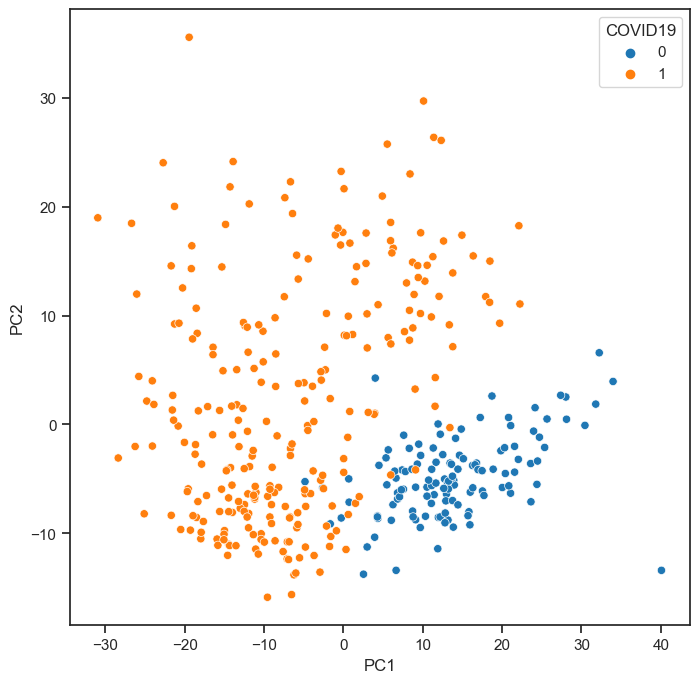

In [36]:
sns.set_style("ticks")
sns.set_context("notebook")
plt.figure(figsize=(8, 8))

p = sns.scatterplot(x=pca_covid[:, 0], y=pca_covid[:, 1], hue=covid_proteomics["COVID19"])

p.set_xlabel("PC1")
p.set_ylabel("PC2")

plt.show()

'18.66%'

Visualise multiple components against each other. Here we make use of the seaborn [pairplot()](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function to do so

In [11]:
# make a dataframe to store the PCA scores for each component alongside the sample metadata
pca_df = pd.DataFrame(pca_covid, columns=["PC"+str(i) for i in range(1, pca_covid.shape[1]+1)])
pca_df["COVID_status"] = covid_proteomics["COVID19"]

pca_df

,PC1,PC2,PC3,PC4,COVID_status
0,6.248566,-7.368579,-4.402010,1.368126,0
1,40.085536,-13.398707,27.836572,4.861265,0
2,11.134484,-4.112733,-3.345271,1.060409,0
3,13.911648,-5.123886,-1.252117,2.484675,0
4,12.754993,-5.008780,-0.698957,-1.045126,0
...,...,...,...,...,...
377,-3.895496,3.509694,7.399634,-3.246642,1
378,-2.500047,-5.893374,4.688830,-3.133457,1
379,-4.886782,-6.005535,0.489567,-3.050764,1
380,-19.003253,7.858747,-1.337151,-3.386067,1


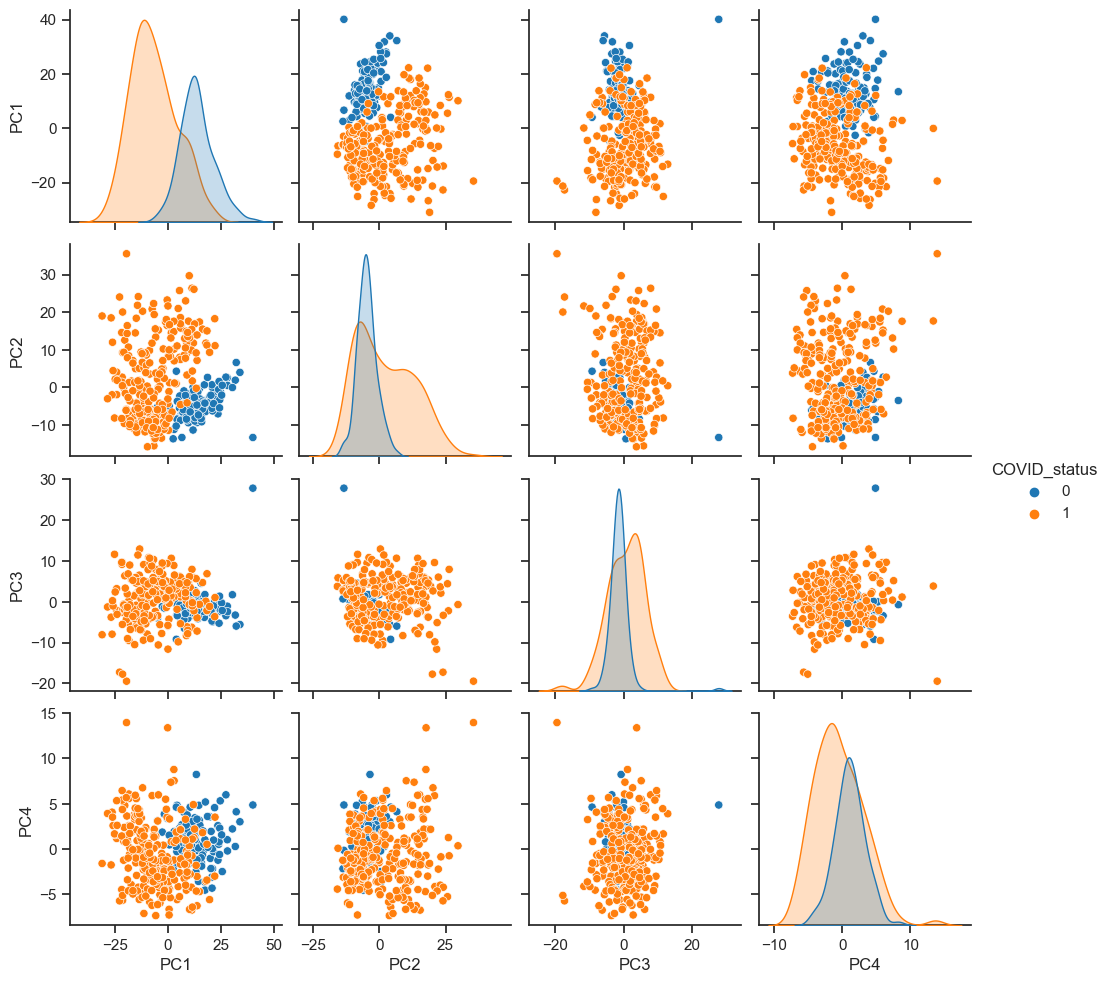

In [12]:
sns.pairplot(data=pca_df, hue="COVID_status")

plt.show()

### Let's plot the first two components and add the variance explained to the axes

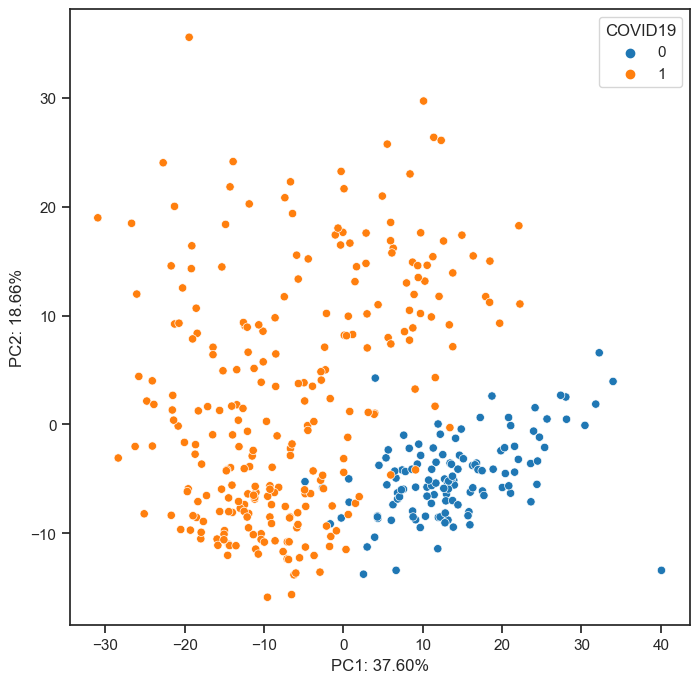

In [37]:
sns.set_style("ticks")
sns.set_context("notebook")
plt.figure(figsize=(8, 8))

p = sns.scatterplot(x=pca_covid[:, 0], y=pca_covid[:, 1], hue=covid_proteomics["COVID19"])

# proportions of variance explained by axes
pvars = pca_res.explained_variance_ratio_[:2] * 100

p.set_xlabel(("PC1: " "{:.2f}%".format(pvars[0])))
p.set_ylabel(("PC2: " "{:.2f}%".format(pvars[1])))

plt.show()

Scree plots show the percentage of the variance in the data explained by each principal component (eigenvalues)

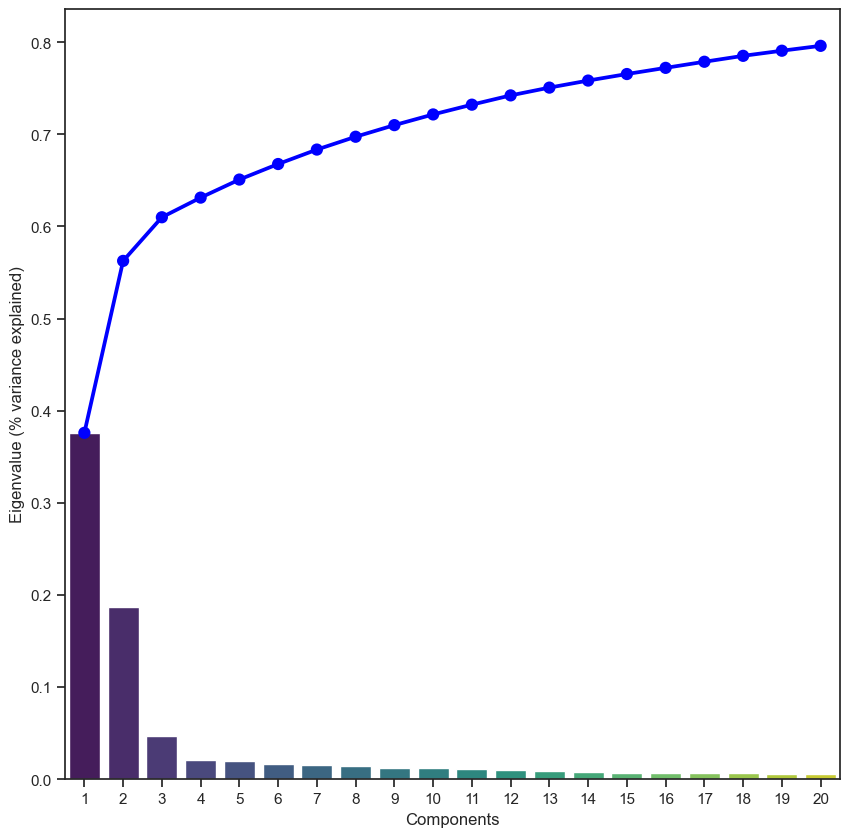

In [13]:
# Scree plot

# perform PCA with 20 components
pca_covid = PCA(n_components=20).fit(covid_proteomics.iloc[:, 3:])

# use the attribute .explained_variance_ratio_ to get the eigenvalues
variance_per_component = pca_covid.explained_variance_ratio_

# sum the eigenvalues to get the cumulative variance explained for each component
cumulative_variance = np.cumsum(variance_per_component)
components = list(range(1, 21))

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x=components, y=variance_per_component, palette="viridis", ax=ax)

# show the cumulative variance with a blue line
sns.pointplot(x=components, y=cumulative_variance, ax=ax, color="blue", label="Cumulative variance")

plt.xlabel("Components")
plt.ylabel("Eigenvalue (% variance explained)")
plt.show()

How many components would be required to explain 75% of the variance in the dataset?

### Interpretation of PCA results

Looking at the PCA scoreplot and the PCA pairplot, which PCA component(s) show the most clear separation between COVID19 and non-COVID samples?

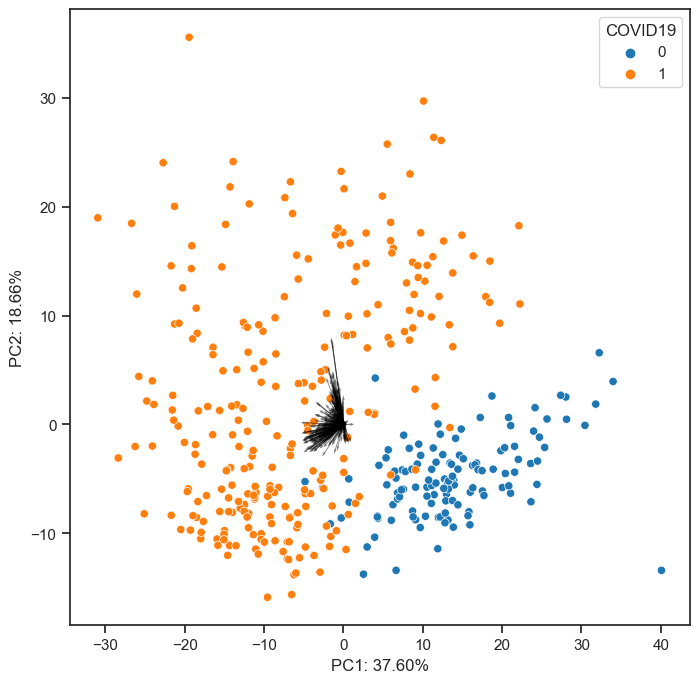

In [50]:
# extracting the scores and loadings (transposing the latter in the process) of the first 2 components (note: this can be different in other datasets)
scores = pca_covid[:, :2]
loadings = pca_res.components_[:2].T
features = list(covid_proteomics.columns[3:])

loadingVector = loadings * np.abs(scores).max(axis=0)

sns.set_style("ticks")
sns.set_context("notebook")
plt.figure(figsize=(8, 8))

p = sns.scatterplot(x=pca_covid[:, 0], y=pca_covid[:, 1], hue=covid_proteomics["COVID19"])

p.set_xlabel(("PC1: " "{:.2f}%".format(pvars[0])))
p.set_ylabel(("PC2: " "{:.2f}%".format(pvars[1])))

# features as arrows
for i, arrow in enumerate(loadingVector):
    plt.arrow(0, 0, *arrow, color='k', alpha=0.5, width=0.1, ec='none', length_includes_head=True)
    #plt.text(*(arrow * 1.05), features[i], ha='center', va='center')

Clearly we have too many variables to visualise in a biplot (hence we have switched off labelling them), let's visualise the most important features in a loading plot instead. (You could only visualise the top few variables above, but how do you know how many to select?)

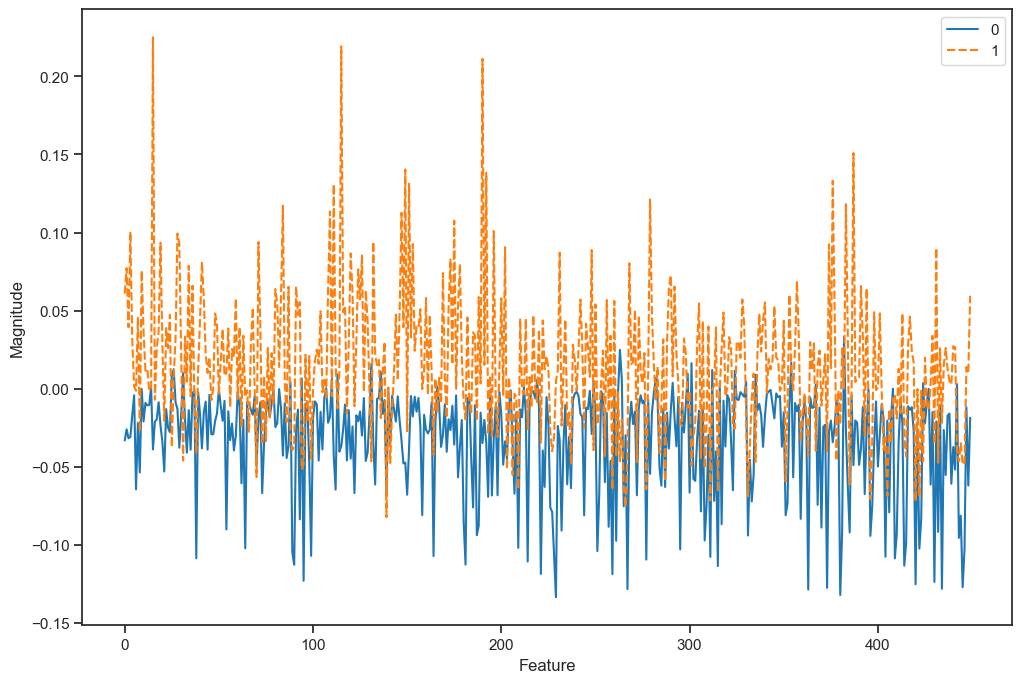

In [56]:
plt.figure(figsize=(12, 8))

lp = sns.lineplot(data=loadings)

lp.set_xlabel("Feature")
lp.set_ylabel("Magnitude")

plt.show()

### Identifying outliers
Samples can be labelled in order to identify those that are outlying

In [14]:
pca_covid = PCA(n_components=2).fit_transform(covid_proteomics.iloc[:, 3:])

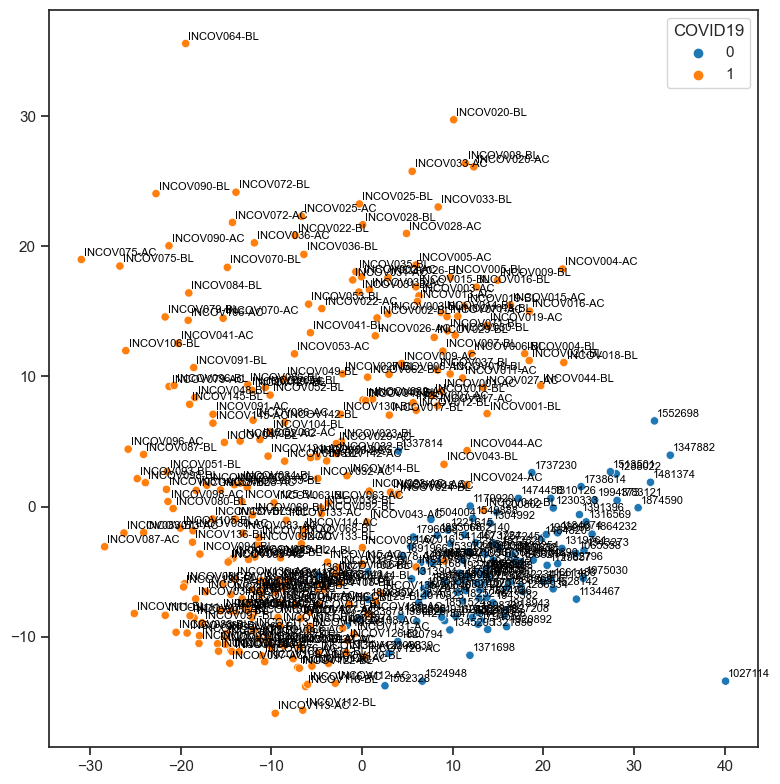

In [15]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=pca_covid[:, 0], y=pca_covid[:, 1], hue=covid_proteomics["COVID19"])

# for loop to add labels to each x, y pair along with the corresponding sample ID
for i in range(pca_covid.shape[0]):
    plt.text(x=pca_covid[:, 0][i]+0.3, y=pca_covid[:, 1][i]+0.3, s=covid_proteomics["sample_id"][i], 
          fontdict=dict(color='black',size=8))

plt.tight_layout()
plt.show()

Are the any obvious outliers in this dataset as seen from this PCA biplot?

## Scaling


The standard score of a sample $x$ is defined as:


$$z = \frac{(x-\mu)}{\sigma}$$

Where:
- $\mu$ is the feature mean
- $\sigma$ is the feature standard deviation



Code a function to scale the data such that each feature has a:
- Mean of 0 
- Standard deviation of 1

Use only the numpy [mean()](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) and numpy [std()](https://numpy.org/doc/stable/reference/generated/numpy.std.html) functions

You can check your answer by comparing it to the result achieved using the sklearn [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#:~:text=Standardize%20features%20by%20removing%20the%20mean%20and%20scaling%20to%20unit%20variance.&text=where%20u%20is%20the%20mean,or%20one%20if%20with_std%3DFalse%20.) function

In [ ]:
def my_scaler(data):
    
    # get mean of each column

    # subtract the column mean from each value in the column

    # check the mean of each column is now 0

    # get the standard deviations of each column

    # divide the mean centered data by the standard deviation to scale by unit variance

    return scaled_data


In [ ]:
# apply the scaler function to the data
covid_proteomics_scaled = my_scaler(covid_proteomics.iloc[:, 3:])

In [ ]:
# perform PCA using the scaled data
pca_covid_scaled = PCA(n_components=2).fit_transform(covid_proteomics_scaled)

How does scaling affect the PCA? visualise the output

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=pca_covid[:, 0], y=pca_covid[:, 1], hue=covid_proteomics["COVID19"], ax=ax1)
ax1.set_title("No scaling")

sns.scatterplot(x=pca_covid_scaled[:, 0], y=pca_covid_scaled[:, 1], hue=covid_proteomics["COVID19"], ax=ax2)
ax2.set_title("Standard scaling")

sklearn also has a number of inbuilt functions for scaling. Look into the following functions and apply them on the dataset:
- [sklearn.StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#:~:text=Standardize%20features%20by%20removing%20the%20mean%20and%20scaling%20to%20unit%20variance.&text=where%20u%20is%20the%20mean,or%20one%20if%20with_std%3DFalse%20.)
- [sklearn.RobustScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html?highlight=robust%20scaler#sklearn.preprocessing.RobustScaler)
- [sklearn.PowerTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html?highlight=power%20transformer#sklearn.preprocessing.PowerTransformer)

Let's begin with appling the PowerTransformer():

In [16]:
# initialise PowerTransformer object
pt = PowerTransformer()

# Apply the power transformation to the data
covid_proteomics_power_transform = pt.fit_transform(covid_proteomics.iloc[:, 3:])

# Apply PCA to the power transformed data
pca_covid_power_transform = PCA(n_components=2).fit_transform(covid_proteomics_power_transform)

Complete the following code for the Standard Scaler and Robust Scaler:

In [17]:
# Standard scaler
ss = StandardScaler()

covid_proteomics_standard_scaled = 

pca_covid_standard_scaled = 

# Robust scaler
rs = 

covid_proteomics_robust_scaled = 

pca_covid_robust_scaled = 

SyntaxError: invalid syntax (2897319308.py, line 4)

Visualise the results of the scaling using PCA biplots

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=pca_covid_power_transform[:, 0], y=pca_covid_power_transform[:, 1], hue=covid_proteomics["COVID19"], ax=ax1)
ax1.set_title("Power transformer")

sns.scatterplot(x=pca_covid_standard_scaled[:, 0], y=pca_covid_standard_scaled[:, 1], hue=covid_proteomics["COVID19"], ax=ax2)
ax2.set_title("Standard scaling")

sns.scatterplot(x=pca_covid_robust_scaled[:, 0], y=pca_covid_robust_scaled[:, 1], hue=covid_proteomics["COVID19"], ax=ax3)
ax3.set_title("Robust scaling")

plt.tight_layout()
plt.show()

# Optional materials

## PCA extensions: sparse PCA and kernel PCA

### Sparse PCA

Sparse PCA is performed using the [SparsePCA()](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA) function. The level of sparsity (the proportion of input variables contributing to the principal components) is controllable by the coefficient of the L1 penalty, given by the parameter `alpha`.

Some algorithms make use of a random process, e.g. to initialise weights it select initial starting points from a random number generator. This means that each time you use the algorithm, the answer might be slightly (sometimes this is unnoticeable) different. Also, this may mean the output you get is different from your neighbour.

How do you get the same answer each time (as long as you do not change any other parameters)? You can set the random state to a specific number.

Random number generators use the computer time and other factors to start at a random place in a huge sequence of random numbers. By setting the ```random_state``` property of an algorithm you will ensure it will start at a standard place. You can pick any positive integer for this. If you look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) and [SparsePCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA) you will see both of these methods have this argument as input, with a default value, however using other default parameters PCA will give the same output whereas the output from SparsePCA might change.

In [ ]:
# enter your CID here, or date of birth, or another number of your choosing to use as random state
# remember to check the documentation of each algorithm if setting the random_state is needed
CID = 0 # do not add the leading 0

In [ ]:
sparse_pca = SparsePCA(n_components=2, alpha=1, random_state=CID)
sparse_pca_covid = sparse_pca.fit_transform(covid_proteomics.iloc[:, 3:])

Look at the mean number of 0 values across the components (sparsity level). How does this change when you change the alpha parameter? 

If `alpha` = 0 there is no sparsity constraint, and all input variables will contribute to the principal components. The higher alpha is, the less variables will contribute to the principal components. 

In [ ]:
np.mean(sparse_pca.components_ == 0)

In [ ]:
sparse_pca_1 = SparsePCA(n_components=2, alpha=1).fit_transform(covid_proteomics.iloc[:, 3:])
sparse_pca_10 = SparsePCA(n_components=2, alpha=10).fit_transform(covid_proteomics.iloc[:, 3:])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=sparse_pca_1[:, 0], y=sparse_pca_1[:, 1], hue=covid_proteomics["COVID19"], ax=ax1)
ax1.set_title("alpha=1")

sns.scatterplot(x=sparse_pca_10[:, 0], y=sparse_pca_10[:, 1], hue=covid_proteomics["COVID19"], ax=ax2)
ax2.set_title("alpha=10")

plt.tight_layout()
plt.show()

### Kernel PCA
We will be discussing more about kernels in BIDS 8, so you can revisit this section after that session.

[Kernel PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) is a form of non-linear dimensionality reduction using kernels. There are several hyperparameters that can be tuned for this model, the main being the type of kernel used. The sklearn KernelPCA() function supports the following kernels: 'linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’, with the default being ’linear’.

In [ ]:
# no kernel has been specified so it uses linear by default
kernel_pca = KernelPCA(n_components=2)
kernel_pca_covid = kernel_pca.fit_transform(covid_proteomics.iloc[:, 3:])

Now try to use another kernel type:

In [ ]:
kernel_pca_rbf = KernelPCA(n_components=2, kernel="rbf").fit_transform(covid_proteomics.iloc[:, 3:])

Experiment with the other parameters listed on the reference page, such as Gamma - the kernel bandwidth parameter.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=kernel_pca_covid[:, 0], y=kernel_pca_covid[:, 1], hue=covid_proteomics["COVID19"], ax=ax1)
ax1.set_title("Linear kernel")

sns.scatterplot(x=kernel_pca_rbf[:, 0], y=kernel_pca_rbf[:, 1], hue=covid_proteomics["COVID19"], ax=ax2)
ax2.set_title("Radial basis function kernel")

plt.tight_layout()
plt.show()

Which kernel type do you think provides the best separation for this dataset?

Visualise the results of the COVID19 dataset using different PCA types:

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x=pca_covid[:, 0], y=pca_covid[:, 1], hue=covid_proteomics["COVID19"], ax=ax1)
ax1.set_title("PCA")

sns.scatterplot(x=sparse_pca_covid[:, 0], y=sparse_pca_covid[:, 1], hue=covid_proteomics["COVID19"], ax=ax2)
ax2.set_title("Sparse PCA")

# if we use linear kernel PCA this will be the same result as standard PCA
sns.scatterplot(x=kernel_pca_covid[:, 0], y=kernel_pca_covid[:, 1], hue=covid_proteomics["COVID19"], ax=ax3)
ax3.set_title("Kernel PCA")

plt.tight_layout()
plt.show()

## Your turn
Select another dataset from the `Data` folder and import it using the pandas `read_excel()` function as above. Scale the data, and then apply PCA (standard, sparse, or kernel) and visualise the results. Reuse the codes above for a new dataset, copy and paste them below.

What can you interpret from the PCA results? Are there any outliers?

In [ ]:
# Import datasets...

In [ ]:
# Perform scaling...

In [ ]:
# Perform PCA...

In [ ]:
# Visualise PCA results and detect outliers